In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr  9 15:41:43 2020.

@author: tagir.farkhutdinov@atco.com
"""

from collections import namedtuple
import numpy as np
# import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp


def partial(array, bc='s'):
    """Compute central discrete differences.

    The assumed inputs are X - x and Y - x.
    Example : partial X over x = partial(solid, 's') + 1.
    """
    result = np.correlate(array, np.array([-0.5, 0., 0.5]), mode='same')
    bc = 'periodic'
    if bc in ('f', 'fluid'):
        result[0] -= 0.5 * array[0]
        result[-1] += 0.5 * array[-1]
    elif bc in ('s', 'solid'):
        result[0] -= 0.
        result[-1] += 0.
    elif bc in ('periodic'):
        result[0] -= 0.5 * array[-1]
        result[-1] += 0.5 * array[0]
    else:
        raise ValueError("Please specify valid boundary conditions.")
    return result


def partial2(array, bc='s'):
    """Compute the second discrete differences.

    The assumed inputs are X and Y.
    Example : partial2 X over x2 = partial2(solid, 's')/partial_x**2.
    """
    result = np.correlate(array, np.array([1., -2., 1.]), mode='same')
    bc = 'periodic'
    if bc in ('f', 'fluid'):
        result[0] += array[0]
        result[-1] += array[-1]
    elif bc in ('s', 'solid'):
        result[0] += 0.
        result[-1] += 0.
    elif bc in ('periodic'):
        result[0] += array[-1]
        result[-1] += array[0]
    else:
        raise ValueError("Please specify valid boundary conditions.")
    return result


def friction_term(solid, solid_t,
                  fluid, fluid_t, partial_x):
    """Compute friction term."""
    partX_x = partial(solid, 's')/partial_x + 1.
    partY_x = partial(fluid, 'f')/partial_x + 1.
    return solid_t / partX_x - fluid_t / partY_x


def pressure_term(solid, fluid, partial_x, args):
    """Compute pressure term."""
    # pylint: disable=W0613
    g_0 = args
    partY_x = partial(fluid, 'f')/partial_x + 1.
    part2X_xx = partial2(solid, 's')/partial_x**2
    part2Y_xx = partial2(fluid, 'f')/partial_x**2
    return partY_x*(g_0**2 * part2Y_xx + (1. - g_0) * part2X_xx)


def stress_term(time, solid, solid_plus_x, partial_x, stress_args=(1., 2)):
    """Compute partial of (sigma_epsilon + S) / partial_x term."""
    T, W = stress_args
#    partX_x = partial(solid, 's')/partial_x + 1.
#    stress_x = (-2. * partX_x * solid_plus_x * np.exp(-time/T) *
#                np.exp(-solid_plus_x**2/W**2) / W**2
#                )
    stress = np.exp(-time / T) * np.exp(-solid_plus_x**2 / W**2)

    stress_x = partial(stress, 'f') / partial_x

    return stress_x


def sigma_term(solid, fluid, x_coord, partial_x, args):
    """Compute sigma_e solid stress term."""
    density_s = partial(solid, 's')/partial_x + 1.
    density_f = partial(fluid, 'f')/partial_x + 1.
    laplace_s = partial2(solid, 's')/partial_x**2
    laplace_f = partial2(fluid, 'f')/partial_x**2
    param_a, param_b, g_0 = args
    return (- 2. * param_a * density_s * laplace_s
            - 2. * param_b
            * (g_0**2*density_f + (1. - g_0)*density_s)
            * (g_0**2*laplace_f + (1. - g_0)*laplace_s))


def two_dynamic_terms(alpha, alpha_t, partial_x, bc):
    """Compute two terms in the lhs of dynamic equations."""
    alpha_x = partial(alpha, bc)/partial_x + 1.
    common = alpha_t / alpha_x
    first = (alpha_t * (partial2(alpha, bc)/partial_x**2) /
             alpha_x)

    second = -2. * partial(alpha_t, bc)/partial_x
    return common*(second + first)


def time_step(time, y, *args):
    """Compute one time step."""
    # pylint: disable=R0914
    solid, solid_t, fluid, fluid_t = np.split(y, 4)
    x_coord = args[0]
    partial_x = (x_coord[-1] - x_coord[0])/(x_coord.size - 1)
    rho_s = 1.
    g0rhof = 0.5
    # lamda = 0.5
    g_0 = 0.5
    K = 0.1
    param_a = 1.
    param_b = 1.0
    S_0 = -1
    nu = 0.0
    friction = friction_term(solid, solid_t,
                             fluid, fluid_t, partial_x)
    pressure = 2 * param_b * g_0 * pressure_term(solid,
                                                 fluid,
                                                 partial_x,
                                                 g_0)
    sigma_e = sigma_term(solid, fluid,
                         x_coord, partial_x,
                         (param_a, param_b, g_0))
    sigma_and_stress = S_0 * stress_term(time, solid,
                                         solid + x_coord,
                                         partial_x) + sigma_e

    delta_solid_t = (-two_dynamic_terms(solid, solid_t, partial_x, 's')
                     - (K*friction
                        + pressure
                        + sigma_and_stress) / rho_s
                     )
    delta_fluid_t = (- two_dynamic_terms(fluid, fluid_t, partial_x, 'f')
                     + (K*friction + pressure) / g0rhof)
    return np.hstack((solid_t + nu*partial2(solid, 's')/partial_x**2,
                      delta_solid_t,
                      fluid_t + nu*partial2(fluid, 'f')/partial_x**2,
                      delta_fluid_t))


Statement = namedtuple('ProblemStatement',
                       ["number_of_intervals",
                        "domain_half_length",
                        "time_interval"])

Solution = namedtuple('ProblemSolution',
                      "x_coord, solid, solid_t, fluid, fluid_t")


def solve(problem_statement):
    """Solve PDE by reduction to IVP for ODE."""
    (number_of_intervals,
     domain_half_length,
     time_interval) = problem_statement
    x_coordinate = np.linspace(-domain_half_length,
                               domain_half_length,
                               number_of_intervals + 1)

    # Solid and fluid represent alpha and beta correspondingly
    solid = np.zeros_like(x_coordinate)
    fluid = np.zeros_like(x_coordinate)
    solid_t = np.zeros_like(solid)
    fluid_t = np.zeros_like(fluid)

    result = solve_ivp(time_step,
                       (time_interval[0], time_interval[-1]),
                       y0=np.hstack((solid, solid_t, fluid, fluid_t)),
                       method='LSODA',
                       t_eval=time_interval,  # time_interval,
                       args=(x_coordinate,)
                       )

    if not isinstance(time_interval, np.ndarray):
        plt.plot(result.t)
        plt.title('Time (y) vs time steps (x).')
        plt.show()

    return Solution(x_coordinate,
                    *np.split(result.y.T, 4, axis=1))


def solve_instance():
    """Solve problem instance."""
    # pylint: disable=W0612
    statement = Statement(number_of_intervals=512,
                          domain_half_length=20.,
                          time_interval=np.linspace(0., 10., 512))

    return statement, solve(statement)


STATEMENT, SOLUTION = solve_instance()


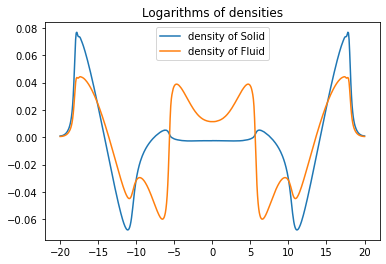

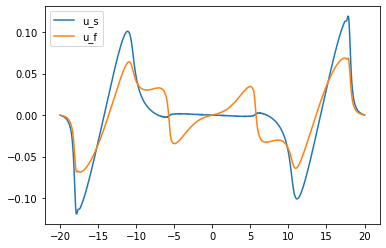

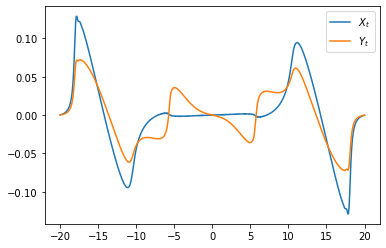

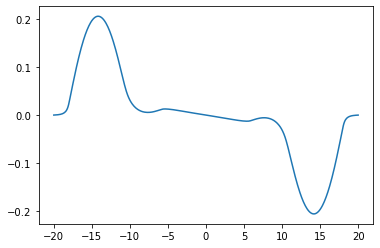

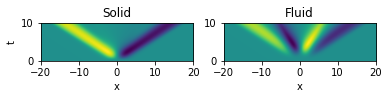

In [2]:
def plot_densities_and_velocities(solution):
    """Plot densities, physical and lagrangian velocities."""
    x_coord, solid, solid_t, fluid, fluid_t = solution
    partial_x = (x_coord[-1] - x_coord[0])/(x_coord.size - 1)
    time_index = solid.shape[0] - 1

    # plt.plot(x_coord, sigma_and_stress_term(0, solid + x_coordinate))
    plt.plot(x_coord, np.log(partial(solid[time_index], 's')/partial_x + 1))
    plt.plot(x_coord, np.log(partial(fluid[time_index], 'f')/partial_x + 1))
    plt.legend(('density of Solid',
                'density of Fluid'))
    plt.title('Logarithms of densities')
    plt.show()

    plt.plot(x_coord, -solid_t[time_index] /
             (partial(solid[time_index], 's')/partial_x + 1.))
    plt.plot(x_coord, -fluid_t[time_index] /
             (partial(fluid[time_index], 'f')/partial_x + 1.))
    plt.legend(('u_s',
                'u_f'))
    plt.show('Physical Velocities')

    plt.plot(x_coord, solid_t[time_index])
    plt.plot(x_coord, fluid_t[time_index])
    plt.legend((r'$X_t$',
                r'$Y_t$'))
    plt.show('Lagrangian Velocities')


plot_densities_and_velocities(SOLUTION)


def plot_evolution(statement, solution):
    """Plot time dynamics."""
    number_of_intervals, domain_half_length, time_interval = statement
    x_coord, solid, solid_t, fluid, fluid_t = solution
    plt.plot(x_coord, solid[-1])
    plt.show()
    time_interval = np.linspace(0., 10.0, 512)

    X, T = np.meshgrid(x_coord, time_interval)
    fig, (ax1, ax2) = plt.subplots(1, 2)
    # ax=fig.gca()
    # ax1=fig.gca(projection='3d')
    # ax.plot_surface(X,T,solid,cmap=cm.coolwarm)
    ax1.imshow(solid,
               extent=[-domain_half_length, domain_half_length, 0, 10],
               origin='lower')
    ax2.imshow(fluid,
               extent=[-domain_half_length, domain_half_length, 0, 10],
               origin='lower')
    # ax.view_init(90,0)
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_title('Solid')
    ax2.set_xlabel('x')
    # ax2.set_ylabel('t')
    ax2.set_title('Fluid')

    # plt.show()
    plt.savefig('plots/Evolution_XY.pdf')
    plt.savefig('plots/Evolution_XY.png')


plot_evolution(STATEMENT, SOLUTION)
